# **Unsupervised Learning of Visual Representations by Solving Jigsaw Puzzles**

Mehdi Noroozi, Paolo Favaro (2016)

https://arxiv.org/abs/1603.09246


**자기 지도 학습(self-supervised learning)**을 통해 시각적 표현(visual representation)을 학습하는 방법을 제안합니다.

이 논문은 레이블이 없는 데이터에서 유용한 특징을 학습하여, 이를 객체 분류나 객체 탐지와 같은 다른 작업에 전이학습(transfer learning)할 수 있도록 하는 것이 목표입니다.

**📌 핵심 아이디어**

이미지를 여러 개의 작은 조각으로 나누고, 이를 섞은 후, 인공지능 모델이 원래의 이미지 순서를 맞추도록 학습하는 방식입니다.

이 과정에서 모델은 **객체의 부분(part)**을 인식하고, 그 부분들이 어떻게 조합되어 전체 객체를 형성하는지를 학습하게 됩니다.

**📌 학습 과정**

1. 이미지 조각 생성

- 이미지를 3x3 격자로 나눠 9개의 패치를 만듭니다.
- 각 패치를 랜덤하게 섞어 모델에 입력합니다.

2. 모델 구조

- 각 패치의 특징을 추출하는 합성곱 신경망(CNN) 사용.
- 각 패치의 특징을 조합하여 순서를 맞추는 작업은 Fully Connected Layer에서 수행됩니다.

3. 손실 함수

- 모델이 예측한 순서와 실제 순서 간 차이를 계산하는 분류 손실 함수를 사용합니다.
- 예를 들어, 9개 조각의 순서는 총
9!(362,880)가지 경우의 수가 있습니다. 모델은 이 중 올바른 순서를 예측해야 합니다.

4. 학습 목표
- 모델은 올바른 순서를 맞추기 위해 패치 간의 관계, 경계, 색상 등을 학습합니다.
- 이 과정에서 모델은 이미지의 전반적인 구조와 문맥적 정보를 이해하게 됩니다.

**📌 전이학습에 유용한 이유**

이 방식으로 학습된 특징은 단순히 퍼즐을 푸는 데 그치지 않고, 이미지 내 객체의 구조적 정보를 잘 포착합니다. 예를 들어, 고양이와 개를 분류하는 문제에서, 고양이의 눈이나 귀 모양과 같은 중요한 특징을 잘 파악한 모델은 다른 작업에서도 더 나은 성능을 발휘할 수 있습니다. 이러한 특징은 이후 객체 분류나 탐지와 같은 작업에 전이되어 높은 성능을 보입니다.

# **Code Review**

ref: https://github.com/bbrattoli/JigsawPuzzlePytorch

## 😌 Easy Version

### **1. 데이터 준비**

먼저 학습할 이미지를 준비하고, 이미지를 여러 조각으로 나눠야 합니다.

split_image 함수는 입력된 이미지를 원하는 격자 크기(grid_size)에 맞춰 자릅니다.

여기서 grid_size=3은 3x3 조각으로 나눔을 의미합니다.

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import random
import numpy as np
import matplotlib.pyplot as plt

# 데이터 변환 설정
transform = transforms.Compose([
    transforms.Resize((255, 255)),  # 이미지 크기 통일
    transforms.ToTensor()
])

img = Image.open("/content/drive/MyDrive/잡동사니/sample.jpeg")  # 샘플 이미지 경로
img = transform(img)

원본 이미지를 보겠습니다.

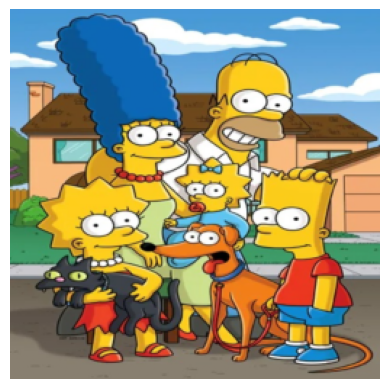

In [2]:
# 이미지를 PIL 형식에서 텐서로 변환
if isinstance(img, Image.Image):  # img가 PIL 이미지인지 확인
    img_tensor = transform(img)
else:
    img_tensor = img  # 이미 텐서인 경우 변환하지 않음

# 텐서를 다시 이미지로 변환하여 시각화 (텐서 -> numpy 배열)
def show_image(tensor):
    """텐서를 이미지로 변환하여 시각화"""
    np_img = tensor.permute(1, 2, 0).numpy()  # [C, H, W] -> [H, W, C]
    np_img = np.clip(np_img, 0, 1)  # 값이 [0, 1] 범위를 넘지 않도록 클리핑
    plt.imshow(np_img)
    plt.axis('off')
    plt.show()

show_image(img_tensor)

심슨이군요. 이제 학습을 위해 이미지를 조각내 보겠습니다.

In [3]:
# 이미지 조각내기
def split_image(img, grid_size=3):
    tiles = []
    h, w = img.shape[1] // grid_size, img.shape[2] // grid_size
    for i in range(grid_size):
        for j in range(grid_size):
            tile = img[:, i*h:(i+1)*h, j*w:(j+1)*w]
            tiles.append(tile)
    return tiles, h, w

# 이미지를 3x3으로 나누기
tiles, tile_h, tile_w = split_image(img_tensor)

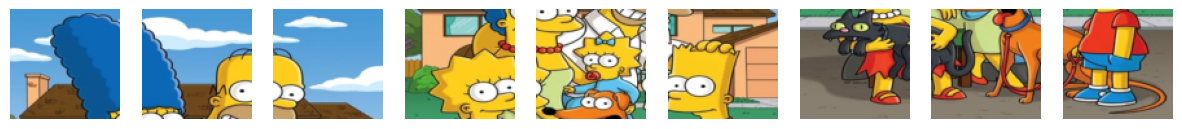

In [4]:
# 조각난 이미지 타일들을 시각화하기
def show_tiles(tiles):
    num_tiles = len(tiles)
    fig, axs = plt.subplots(1, num_tiles, figsize=(15, 5))
    for i in range(num_tiles):
        axs[i].imshow(tiles[i].permute(1, 2, 0))  # [C, H, W] -> [H, W, C]
        axs[i].axis('off')
    plt.show()

show_tiles(tiles)

### **2. 이미지 조각 랜덤 섞기**

조각들을 랜덤으로 섞어 학습에 사용할 데이터를 생성합니다.

shuffle_tiles 함수는 이미지 조각을 섞어서 모델이 순서를 추정할 수 있도록 합니다.

original_order는 섞이기 전 원래 순서입니다.

In [5]:
# 이미지 조각을 섞기
def shuffle_tiles(tiles):
    idx = list(range(len(tiles)))
    random.shuffle(idx)
    shuffled_tiles = [tiles[i] for i in idx]
    return shuffled_tiles, idx

shuffled_tiles, original_order = shuffle_tiles(tiles)

잘 섞였는지 볼까요.

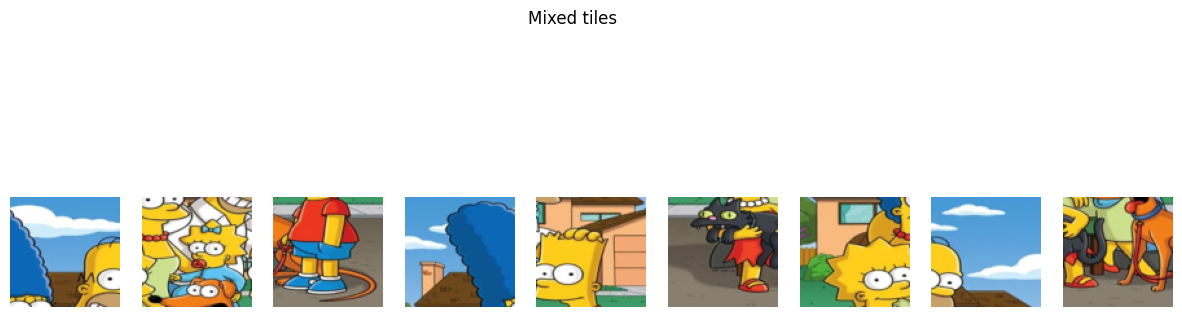

In [6]:
# 조각난 이미지 타일들을 시각화하기
def show_tiles(tiles, title=""):
    num_tiles = len(tiles)
    fig, axs = plt.subplots(1, num_tiles, figsize=(15, 5))
    for i in range(num_tiles):
        axs[i].imshow(tiles[i].permute(1, 2, 0))  # [C, H, W] -> [H, W, C]
        axs[i].axis('off')
    plt.suptitle(title)
    plt.show()

show_tiles(shuffled_tiles, title="Mixed tiles")

### **3. Jigsaw 퍼즐 모델 정의**

비지도 학습 모델을 정의하여 이미지 조각들의 순서를 맞춰보도록 합니다.

간단한 CNN 모델로 각 이미지 조각을 입력받아 특징을 추출하고, 최종 출력층에서 9개의 조각 순서를 맞추기 위한 예측을 진행합니다.

In [7]:
class JigsawPuzzleModel(nn.Module):
    def __init__(self, tile_h, tile_w):
        super(JigsawPuzzleModel, self).__init__()

        # 컨볼루션 블록 정의
        self.conv = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )

        # Conv 출력 크기 계산
        with torch.no_grad():
            sample_tile = torch.zeros(1, 3, tile_h, tile_w)
            conv_output = self.conv(sample_tile)
            self.conv_output_size = int(np.prod(conv_output.size()[1:]))  # [B, C, H, W]에서 C*H*W 계산

        # Fully Connected Layer 정의
        self.fc = nn.Linear(self.conv_output_size, 9)

    def forward(self, x):
        """
        Forward 함수는 입력된 이미지 타일들에 대해 순차적으로 연산을 수행합니다.
        """
        # 각 타일에 대해 Conv 연산 수행
        x = [self.conv(tile.unsqueeze(0)) for tile in x]  # [B, C, H, W]

        # Conv 결과를 Flatten하여 벡터로 변환
        x = [tile.view(-1) for tile in x]  # [C*H*W]

        # 모든 타일 벡터를 병합하여 하나의 큰 벡터로 만듦
        x = torch.stack(x)  # [B, Flatten된 벡터]

        # 각 타일에 대해 Fully Connected Layer 적용
        x = self.fc(x)  # [B, 9]
        return x

# 모델 초기화
model = JigsawPuzzleModel(tile_h=tile_h, tile_w=tile_w)

**모델 아키텍쳐**

입력: [9개의 이미지 타일] -> 각각의 크기: [3 x tile_h x tile_w]

1. 첫 번째 컨볼루션 레이어:
   - 입력: [3 x tile_h x tile_w]
   - 출력: [64 x (tile_h/2) x (tile_w/2)] (stride=2로 인해 크기가 절반으로 줄어듦)

2. 두 번째 컨볼루션 레이어:
   - 입력: [64 x (tile_h/2) x (tile_w/2)]
   - 출력: [128 x (tile_h/4) x (tile_w/4)] (stride=2로 인해 다시 절반으로 줄어듦)

3. Flatten:
   - 출력: [(128 * (tile_h/4) * (tile_w/4))] -> 1차원 벡터로 변환

4. Fully Connected Layer:
   - 입력: [Flatten된 벡터]
   - 출력: [9개의 클래스] -> 각 타일이 어느 위치에 있어야 하는지 예측

최종 출력: 각 타일에 대해 예측된 순서 값들 -> 총 9개의 숫자

### **4. 학습 및 평가**

이제 모델을 학습시키고, 모델이 얼마나 잘 맞추는지 평가합니다.

In [8]:
# 손실 함수 및 최적화 도구 정의
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 학습 과정에서 손실 값을 저장할 리스트
loss_history = []

# 데이터셋과 에폭 설정
epochs = 10

for epoch in range(epochs):
    optimizer.zero_grad()

    # 모델의 예측값 계산 (섞인 타일들에 대해)
    outputs = model(shuffled_tiles)

    # original_order를 LongTensor로 변환하여 손실 함수에 맞게 적용 (타겟: [9])
    loss = criterion(outputs.squeeze(), torch.tensor(original_order).long())

    # 역전파 및 최적화 수행
    loss.backward()
    optimizer.step()

    # 손실 값 저장 (시각화를 위해)
    loss_history.append(loss.item())

    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

Epoch [1/10], Loss: 2.2080
Epoch [2/10], Loss: 1.5724
Epoch [3/10], Loss: 0.6955
Epoch [4/10], Loss: 0.2955
Epoch [5/10], Loss: 0.0583
Epoch [6/10], Loss: 0.0290
Epoch [7/10], Loss: 0.0131
Epoch [8/10], Loss: 0.0033
Epoch [9/10], Loss: 0.0007
Epoch [10/10], Loss: 0.0002


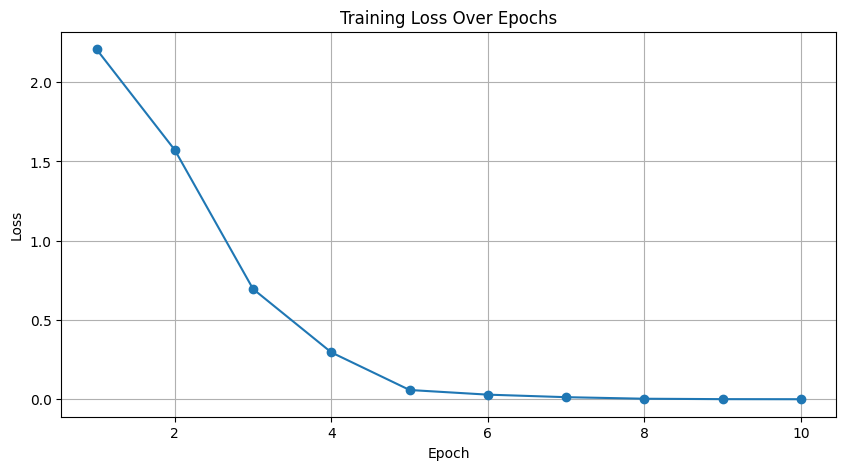

In [9]:
# 학습 과정에서의 손실 값 시각화
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), loss_history, marker='o')
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

In [10]:
# 학습 후 모델이 예측한 타일 순서 확인
with torch.no_grad():
    predicted_order = model(shuffled_tiles).argmax(dim=1).cpu().numpy()

print(f"Original Order: {original_order}")
print(f"Predicted Order: {predicted_order}")

Original Order: [1, 4, 8, 0, 5, 6, 3, 2, 7]
Predicted Order: [1 4 8 0 5 6 3 2 7]


이제 좀 더 큰 데이터로 전이학습을 해보죠.

## 🧐 Transfer Learning 실습: ResNet-18 모델을 사용한 CIFAR-10 이미지 분류

이 실습에서는 PyTorch의 **전이 학습(Transfer Learning)**을 사용하여 사전 학습된 모델을 새로운 데이터셋에 맞게 미세 조정(fine-tuning)하는 방법을 다룹니다.

ImageNet 데이터로 사전 학습된 ResNet-18 모델을 사용하여 CIFAR-10 데이터셋에서 이미지 분류 작업을 수행할 것입니다.




📌 Transfer Learning 적용 시 주의사항

1. **데이터셋의 유사성**
- 사전 학습된 모델이 학습한 데이터와 새로운 데이터가 **유사**할수록 성능이 더 높아집니다.

- 예시: ImageNet으로 학습된 모델은 일반적인 이미지 분류에 적합하지만, 특화된 도메인(예: 의료 이미지)에서는 추가적인 미세 조정(Fine-tuning)이 필요합니다.


2. **Fine-tuning 전략**
- 초기 레이어 고정 (Freezing):
  - 학습 초기에는 모델의 앞부분 레이어를 고정하여 이미 학습된 기본 특징(Edges, Textures)을 활용합니다.

- 점진적 Unfreezing:
  - 학습이 진행되면 점진적으로 고정된 레이어를 풀어(Unfreeze) 세부 조정을 진행합니다.


3. **과적합(Overfitting) 방지**
- 새로운 데이터셋이 작을 경우, 전체 네트워크를 미세 조정하면 과적합 가능성이 높습니다.

- 해결책:
  - 데이터 증강(Data Augmentation) 활용
  - 규제화 기법(Regularization) 적용
  - 적절한 Early Stopping 사용


🙋‍♂️ CIFAR-10이 뭔가요?

https://paperswithcode.com/dataset/cifar-10

**CIFAR-10**은 기계 학습과 컴퓨터 비전 분야에서 널리 사용되는 **이미지 데이터셋**으로, 이미지 분류 및 객체 인식 실험에 자주 활용됩니다. Canadian Institute for Advanced Research에서 개발되었습니다.

---

**CIFAR-10의 주요 특징**

✅ 데이터 구성
- **크기**: 총 60,000개의 컬러 이미지
- **학습용 데이터**: 50,000개 이미지
- **테스트용 데이터**: 10,000개 이미지
- **이미지 크기**: `32 x 32` 픽셀 (RGB 이미지)

✅ 클래스

CIFAR-10은 10개의 클래스로 구성되어 있습니다.

1. 비행기 (`airplane`)
2. 자동차 (`automobile`)
3. 새 (`bird`)
4. 고양이 (`cat`)
5. 사슴 (`deer`)
6. 개 (`dog`)
7. 개구리 (`frog`)
8. 말 (`horse`)
9. 배 (`ship`)
10. 트럭 (`truck`)

각 클래스는 동일한 수의 이미지(6,000개)를 포함하고 있습니다.

✅ 용도

CIFAR-10은 다양한 딥러닝 및 머신러닝 모델의 성능을 비교하거나 학습하는 데 사용됩니다.
- 이미지 분류
- 모델 성능 검증
- 전이 학습 실험

### **1. 환경 설정 및 패키지 설치**

먼저, 필요한 패키지를 설치하고 PyTorch 환경을 설정합니다.

In [18]:
# PyTorch 및 torchvision 설치
!pip install torch torchvision --quiet

# 필요한 라이브러리 임포트
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
import numpy as np
import matplotlib.pyplot as plt
import time
import os

# GPU 사용 가능 여부 확인
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


### **2. CIFAR-10 데이터셋 준비**

이미지를 전처리하고, 학습 및 검증 데이터를 준비합니다.

In [16]:
# 데이터 전처리 설정 (이미지 크기 조정 및 정규화)
transform_train = transforms.Compose([
    transforms.Resize(40),                 # 이미지를 40x40으로 리사이즈
    transforms.RandomCrop(32, padding=4),  # 랜덤으로 32x32로 크롭 (데이터 증강)
    transforms.RandomHorizontalFlip(),     # 랜덤으로 이미지를 좌우 반전하여 데이터 증강
    transforms.ToTensor(),                 # 이미지를 텐서로 변환
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # 정규화 (평균과 표준편차)
])

transform_test = transforms.Compose([
    transforms.ToTensor(),                 # 이미지를 텐서로 변환
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # 정규화 (평균과 표준편차)
])

# CIFAR-10 데이터 로드 (훈련 및 테스트 셋)
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


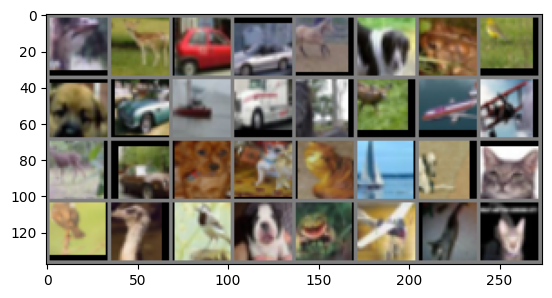

bird deer automobile automobile horse dog frog bird


In [19]:
# 샘플 이미지 시각화 (훈련 데이터에서 일부 이미지를 시각화)
def imshow(img):
    img = img / 2 + 0.5  # 정규화 해제
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # [C,H,W] -> [H,W,C]
    plt.show()

# 샘플 이미지 가져오기
dataiter = iter(train_loader)
images, labels = next(dataiter)  # 수정된 부분

# 이미지 출력
imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{train_dataset.classes[labels[j]]}' for j in range(8)))

### **3. Pre-trained ResNet-18 모델 불러오기 및 미세 조정 (Fine-tuning)**

이제 ImageNet으로 사전 학습된 ResNet-18 모델을 불러와서 CIFAR-10 데이터셋에 맞게 **미세 조정(fine-tuning)**을 진행하겠습니다.

In [20]:
# ResNet-18 모델 불러오기 및 수정
model = models.resnet18(pretrained=True)

# 마지막 출력 레이어를 CIFAR-10에 맞게 수정 (CIFAR-10은 10개 클래스)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)

# 모델을 GPU로 이동
model = model.to(device)

# 모델 구조 시각화 (ResNet 구조 출력)
from torchsummary import summary
summary(model, (3, 32, 32))  # 입력 크기는 CIFAR-10의 이미지 크기인 [3 x 32 x 32]

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

### **4. 손실 함수 및 최적화 도구 설정**

모델을 학습시키기 위한 손실 함수와 최적화 방법을 설정합니다.

In [21]:
# 손실 함수 및 최적화 도구 정의
criterion = nn.CrossEntropyLoss()  # 분류 작업을 위한 손실 함수
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam 옵티마이저 사용

# 학습률 감소 스케줄러 설정 (학습 진행에 따라 학습률 감소)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

### **5. 모델 학습 함수 정의**

모델을 학습시키는 함수를 정의합니다.

In [22]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=5):
    train_loss_history = []
    test_loss_history = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')

        for phase in ['train', 'test']:
            dataloader = train_loader if phase == 'train' else test_loader

            if phase == 'train':
                model.train()  # 훈련 모드로 설정
            else:
                model.eval()   # 평가 모드로 설정

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            if phase == 'train':
                train_loss_history.append(epoch_loss)
            else:
                test_loss_history.append(epoch_loss)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        scheduler.step()

    # 손실 값 시각화 (훈련 & 테스트 손실 값 비교)
    plt.figure(figsize=(8,6))
    plt.plot(train_loss_history, label='Train Loss')
    plt.plot(test_loss_history, label='Test Loss')
    plt.title('Train vs Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    return model

Epoch 1/5
train Loss: 1.4126 Acc: 0.5084
test Loss: 1.4955 Acc: 0.5509
Epoch 2/5
train Loss: 1.1325 Acc: 0.6120
test Loss: 1.2941 Acc: 0.5577
Epoch 3/5
train Loss: 1.0052 Acc: 0.6564
test Loss: 0.9602 Acc: 0.6809
Epoch 4/5
train Loss: 0.9103 Acc: 0.6886
test Loss: 1.1128 Acc: 0.6359
Epoch 5/5
train Loss: 0.8481 Acc: 0.7096
test Loss: 1.6506 Acc: 0.5565


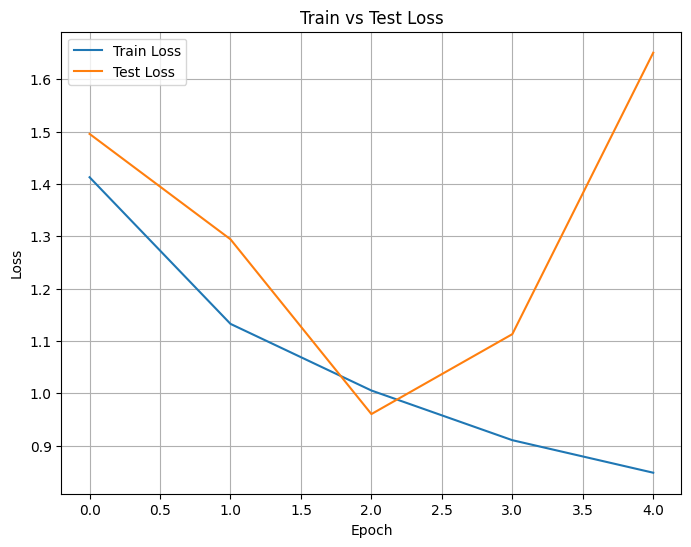

In [23]:
# 학습 실행
model_trained = train_model(model, criterion, optimizer, scheduler)

Test Loss는 초기에 감소하다가 3 epoch 이후에 다시 증가합니다.

오버피팅(overfitting)으로 보이네요.

일단 계속 할게요.

### **6. 테스트 및 평가**

훈련이 완료되면 테스트 데이터셋에서 모델 성능을 평가합니다.

In [24]:
def test_model(model):
    model.eval()   # 평가 모드로 전환 (Dropout 등 비활성화)

    corrects = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            corrects += torch.sum(preds == labels.data)

    accuracy = corrects.double() / len(test_loader.dataset)

    print(f'Test Accuracy: {accuracy:.4f}')

Test Accuracy: 0.5565


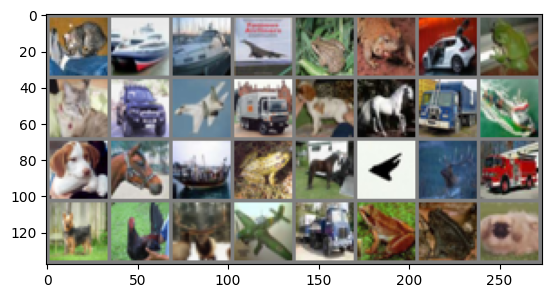

Predicted:  frog automobile automobile bird frog frog automobile frog
Actual:  cat ship ship airplane frog frog automobile frog


In [26]:
# 모델 테스트 실행 및 정확도 확인
test_model(model_trained)

# 테스트 결과 시각화 (예측 결과와 실제 라벨 비교하기 위한 샘플 출력)
dataiter = iter(test_loader)
images, labels = next(dataiter)  # 수정된 부분

outputs = model_trained(images.to(device))
_, preds = torch.max(outputs.cpu(), dim=1)

imshow(torchvision.utils.make_grid(images))
print('Predicted: ', ' '.join(f'{train_dataset.classes[preds[j]]}' for j in range(8)))
print('Actual: ', ' '.join(f'{train_dataset.classes[labels[j]]}' for j in range(8)))

형편없군요!

끝입니다. 이제.

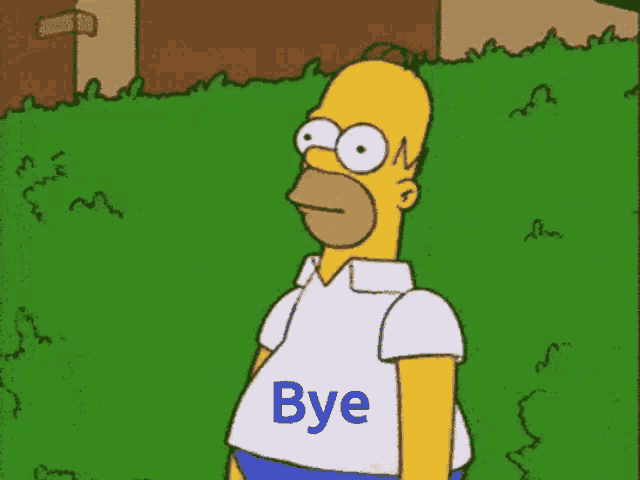